This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [1]:
figname = '../paper/fig_result'

In [2]:
%run 0_parameters.ipynb


This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
2019-03-14
{'w': 28, 'minibatch_size': 100, 'train_batch_size': 100, 'test_batch_size': 1000, 'noise_batch_size': 1000, 'mean': 0.1307, 'std': 0.3081, 'N_pic': 128, 'offset_std': 8, 'offset_max': 35, 'noise': 0.5, 'contrast': 0.9, 'sf_0': 0.2, 'B_sf': 0.3, 'N_theta': 6, 'N_azimuth': 16, 'N_eccentricity': 10, 'N_phase': 2, 'N_X': 128, 'N_Y': 128, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.5, 'dim1': 1000, 'dim2': 1000, 'loss_func': BCEWithLogitsLoss(), 'lr': 0.01, 'do_adam': True, 'epochs': 40, 'bn1_bn_momentum': 0.5, 'bn2_bn_momentum': 0.5, 'momentum': 0.1, 'n_epochs': 10, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-03-14', 'seed': 2019}
2019-03-14T10:02:35+01:00

CPython 3.7.2
IPython 7.3.0

numpy 1.16.2
matplotlib 3.0.2
torch 1.0.1.post2

compiler   : Clang 10.0.0 (clang-1

# Network

In [3]:
from retina import Display
d = Display(args)

from retina import Retina
r = Retina(args)

from where import Where
where = Where(args, d, r)

filename_train = args.filename + '_train3.pt'
%ls -lh {filename_train}
%rm {filename_train}
#filename_train = '../data/2019-03-11_CNS.npy'

Loading accuracy... min, max= 0.0145 0.9852
ls: ../data/2019-03-14_train3.pt: No such file or directory


In [4]:
%prun where.train(filename_train)

Train Epoch: 100%|██████████| 40/40 [1:07:37<00:00, 101.43s/it]

Model saved at ../data/2019-03-14_train3.pt
 

         157947173 function calls (157918514 primitive calls) in 4057.220 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   408000 2362.147    0.006 3258.011    0.008 retina.py:50(retina)
   408000  256.331    0.001  442.983    0.001 SLIP.py:576(olshausen_whitening_filt)
   408000  207.487    0.001  230.471    0.001 retina.py:160(accuracy_fullfield)
   408000  164.678    0.000  164.678    0.000 SLIP.py:588(low_pass)
   816000  126.807    0.000  126.807    0.000 {built-in method numpy.fft.fftpack_lite.cfftb}
   816000  116.770    0.000  116.770    0.000 {built-in method numpy.fft.fftpack_lite.cfftf}
   408000  111.306    0.000  229.103    0.001 retina.py:254(place_object)
     4080   73.219    0.018   73.219    0.018 {method 'run_backward' of 'torch._C._EngineBase' objects}
  1632000   59.281    0.000   70.912    0.000 numeric.py:1401(roll)
   408000   44.565    0.000  433.901    0.001 SLIP.py:518(FTfilter)
     4080   36.8

#### Training

In [5]:
%%writefile train.py
import easydict
args = easydict.EasyDict({'w': 28, 'minibatch_size': 60, 'train_batch_size': 1000, 'test_batch_size': 20, 'mean': 0.1307, 'std': 0.3081, 'N_pic': 128, 'offset_std': 8, 'offset_max': 35, 'noise': 0.1, 'contrast': 0.9, 'sf_0': 0.2, 'B_sf': 0.3, 'N_theta': 6, 'N_azimuth': 16, 'N_eccentricity': 10, 'N_phase': 2, 'N_X': 128, 'N_Y': 128, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.0, 'dim1': 1000, 'dim2': 1000, 'loss_func': BCEWithLogitsLoss(), 'lr': 0.01, 'do_adam': False, 'epochs': 20, 'momentum': 0.1, 'n_epochs': 10, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-03-13', 'seed': 2019})
from retina import Display, Retina
from where import Where
where = Where(args, Display(args), Retina(args))
filename_train = args.filename + '_train.pt'
where.train(filename_train)

Overwriting train.py


In [6]:
def test(net, optimizer=where.optimizer,
         vsize=args.N_theta*args.N_azimuth*args.N_eccentricity*args.N_phase,
         asize=args.N_azimuth*args.N_eccentricity):
    
    data, label = next(iter(d.loader_test))
    batch_size = label.shape[0]

    retina_data = np.zeros((batch_size, args.N_phase * args.N_theta * args.N_azimuth * args.N_eccentricity))
    fixmap_data = np.zeros((batch_size, args.N_azimuth * args.N_eccentricity))

    for i in range(batch_size):
            data_fullfield, i_offset, j_offset = d.draw(data[i, 0, :, :].numpy())
            retina_data[i, :]  =  r.retina(data_fullfield)
            accuracy_colliculus[i,:], _ = r.accuracy_fullfield(accuracy_map, i_offset, j_offset)
            
    retina_data = Variable(torch.FloatTensor(retina_data))
    accuracy_colliculus = Variable(torch.FloatTensor(accuracy_colliculus))
    
    with torch.no_grad():
        output = net(retina_data)
        acc, _ = accuracy_gain(output, accuracy_colliculus, batch_size)

    return acc


## Anywhere target, with noise

# Visualisation of some examples

In [7]:
data, label = next(iter(d.loader_test))
full, retina_data, accuracy_colliculus = where.minibatch(data)

In [8]:
data.shape, retina_data.shape, accuracy_colliculus.shape

(torch.Size([1000, 1, 28, 28]),
 torch.Size([1000, 1920]),
 torch.Size([1000, 160]))

In [9]:
retina_data


tensor([[-0.0618, -0.0071,  0.0346,  ...,  0.1113,  0.3413, -0.4980],
        [-0.0899, -0.2037,  0.0311,  ...,  0.1369,  0.3231, -0.4527],
        [-0.2028,  0.0786,  0.0561,  ...,  0.1671,  0.2943, -0.5456],
        ...,
        [-0.0448,  0.0306,  0.0583,  ..., -0.0496,  0.2802, -0.5931],
        [ 0.0654,  0.0060,  0.0052,  ...,  0.1060,  0.2296, -0.6633],
        [-0.0231,  0.0131, -0.0348,  ..., -0.3643,  0.2480, -0.7871]])

In [10]:
where.model.eval()

WhereNet(
  (bn1): Linear(in_features=1920, out_features=1000, bias=True)
  (bn1_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (bn2): Linear(in_features=1000, out_features=1000, bias=True)
  (bn2_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (bn3): Linear(in_features=1000, out_features=160, bias=True)
)

In [11]:
where.model(retina_data)


tensor([[-2.5370, -2.6631, -2.7424,  ..., -2.1589, -2.1434, -2.1393],
        [-0.0046, -0.9664, -1.8473,  ..., -2.2123, -2.1978, -2.1921],
        [ 0.1298,  0.6103, -0.2287,  ..., -2.0950, -2.1320, -2.1399],
        ...,
        [-2.6190, -2.2220, -1.9724,  ..., -2.1661, -2.1389, -2.1372],
        [-1.8437, -1.7956, -1.9083,  ..., -2.1444, -2.1462, -2.1541],
        [-1.9308, -1.6891, -1.5451,  ..., -1.7553, -2.0390, -2.0880]],
       grad_fn=<AddmmBackward>)

## knowing the target

In [12]:
accuracy_colliculus.shape, accuracy_colliculus.min(), accuracy_colliculus.max()

(torch.Size([1000, 160]), tensor(0.0282), tensor(0.9067))

In [14]:
from torch.autograd import Variable
import torch.nn.functional as F

out_t = where.model(retina_data)
out_sig = F.sigmoid(out_t).detach().numpy()
    
out_t.shape, out_sig.shape

(torch.Size([1000, 160]), (1000, 160))

AttributeError: 'Retina' object has no attribute 'K_whitening'

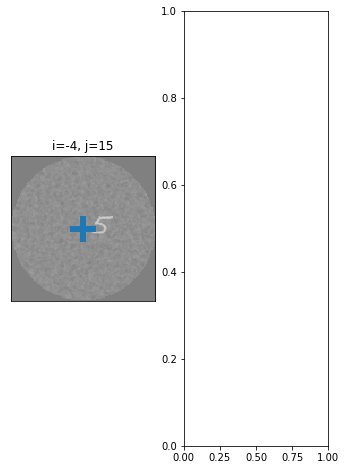

In [15]:
#for idx in range(args.test_batch_size): #range(3, 7):
for idx in range(3, 7):
    fig = plt.figure(figsize = (15, 8))
    
    ax = fig.add_subplot(151)
    ax = d.show(ax, full[idx]['data_fullfield'])
    ax.set_title(f"i={full[idx]['i_offset']}, j={full[idx]['j_offset']}")
    
    ax = fig.add_subplot(152)
    #ax = r.show(ax, r.retina_invert(retina_data[idx, :].numpy()))
    data_retina = r.retina(full[idx]['data_fullfield'])
    ax = r.show(ax, r.retina_invert(data_retina))
    ax.set_title(f"idx={idx}")
              
    ax = fig.add_subplot(153, projection='polar')
    ax.pcolor(r.theta, r.log_r, accuracy_colliculus[idx, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())

    #col = colliculus_inverse @ a_data_n[idx,0,:]
    #vec_t = Variable(torch.FloatTensor(accuracy_colliculus[idx, :].numpy()))
    #vec_t = vec_t.reshape((1, args.N_azimuth * args.N_eccentricity))
                 
    #out_t = out_t.reshape((1, args.N_azimuth * args.N_eccentricity))
    #acc, _ = accuracy_gain(out_t, vec_t, 1, full_fixmap = full_fixmap_n[idx, :].reshape((1, -1)))
    #view = r.colliculus_inverse @ out_sig.flatten()

    ax = fig.add_subplot(154, projection='polar')
    ax.pcolor(r.theta, r.log_r, out_sig[idx, :].reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())

    ax = fig.add_subplot(155)
    im = where.extract(full[idx]['data_fullfield'], full[idx]['i_offset'], full[idx]['j_offset'])
    ax.imshow(im, cmap=plt.gray())

    proba = where.classify_what(im)
    pred = proba.argmax() # get the index of the max log-probability
    acc = proba[0, pred]
    result = '' if pred==label[idx] else 'FALSE'
    ax.set_title(f"pred={pred} acc={acc:.2f} {result}")
                 

## NOT knowing the target

In [ ]:
# Predict classes using images from the train set
prediction = where.model(retina_data)


In [ ]:
prediction.shape

In [ ]:
torch.optim.Adam?

In [ ]:
from torch.autograd import Variable
import torch.nn.functional as F


#for idx in range(args.test_batch_size): #range(3, 7):
for idx in range(3, 7):
    fig = plt.figure(figsize = (15, 8))
    
    ax = fig.add_subplot(151)
    ax = d.show(ax, full[idx]['data_fullfield'])
    ax.set_title(f"i={full[idx]['i_offset']}, j={full[idx]['j_offset']}")
    
    ax = fig.add_subplot(152)
    #ax = r.show(ax, r.retina_invert(retina_data[idx, :].numpy()))
    data_retina = r.retina(full[idx]['data_fullfield'])
    ax = r.show(ax, r.retina_invert(data_retina))
    ax.set_title(f"idx={idx}")
              
    ax = fig.add_subplot(153, projection='polar')
    #col = colliculus_inverse @ a_data_n[idx,0,:]
    vec_t = Variable(torch.FloatTensor(accuracy_colliculus[idx, :].numpy()))
    vec_t = vec_t.reshape((1, args.N_azimuth * args.N_eccentricity))
    ax.pcolor(r.theta, r.log_r, vec_t.reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    out_t = where.model(retina_data[idx, :])
    out_sig = F.sigmoid(out_t).detach().numpy()
    out_t = out_t.reshape((1, args.N_azimuth * args.N_eccentricity))
    #acc, _ = accuracy_gain(out_t, vec_t, 1, full_fixmap = full_fixmap_n[idx, :].reshape((1, -1)))
    view = r.colliculus_inverse @ out_sig.flatten()

    ax = fig.add_subplot(154, projection='polar')
    ax.pcolor(r.theta, r.log_r, out_sig.reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())

    ax = fig.add_subplot(155)
    im = where.extract(full[idx]['data_fullfield'], full[idx]['i_offset'], full[idx]['j_offset'])
    ax.imshow(im, cmap=plt.gray())

    proba = where.classify_what(im)
    pred = proba.argmax() # get the index of the max log-probability
    acc = proba[0, pred]
    result = '' if pred==label[idx] else 'FALSE'
    ax.set_title(f"pred={pred} acc={acc:.2f} {result}")
                 

In [ ]:
def test_eccentricities(N_eccentricities=9):
    vsize = args.N_theta*args.N_azimuth*args.N_eccentricity*args.N_phase
    asize = args.N_azimuth*args.N_eccentricity
    
    N_pic_mnist = 28
    N_class_mnist = 10

    test_batch_size = 1000
    
    mem_acc_log = []
    mem_acc_data_log = []
    mem_ref_log = [] 
    mem_ref_data_log = []

    ecc_max=.8
    r_pix = []

    eccentricities = range(N_eccentricities)
    for i_eccentricity in eccentricities:

        eccentricity = ecc_max * (1/args.rho)**(args.N_eccentricity - i_eccentricity)

        radius = args.N_pic / 2 * eccentricity
        print('at scale ', i_eccentricity, ' radius=', radius)
        r_pix.append(radius)

        data, label = next(iter(d.loader_test))

        input_n = np.zeros((args.test_batch_size, 1, vsize))
        a_data = np.zeros((args.test_batch_size, asize))
        full_fixmap_n = np.zeros((args.test_batch_size, args.N_pic**2))

        ref_data = np.zeros(test_batch_size)

        for idx in range(test_batch_size):
            theta = np.random.rand() * 2 * np.pi
            i_offset = int(radius * np.cos(theta))
            j_offset = int(radius * np.sin(theta))

            # changed
            data_fullfield = d.place_object(data[idx, 0, :, :].numpy(), i_offset, j_offset)
            input_n[idx, 0, :]  =  r.retina(data_fullfield)

            a_data[idx, :], accuracy_fullfield_map = r.accuracy_fullfield(accuracy_map, i_offset, j_offset)
            full_fixmap_n[idx, :] = accuracy_fullfield_map.flatten()

            # when we do not do a saccade, the reference accurracy data is pre-computed 
            if radius <= N_pic_mnist:
                ref_data[idx] = accuracy_map[N_pic_mnist - 1 + i_offset, N_pic_mnist - 1 + j_offset]
            else:
                ref_data[idx] = 1 / N_class_mnist      


        in_t = Variable(torch.FloatTensor(input_n))
        out_t = net(in_t)
        a_data_t = Variable(torch.FloatTensor(a_data))
        acc, acc_data = accuracy_gain(out_t, a_data_t, test_batch_size, full_fixmap=full_fixmap_n)
        mem_acc_log += [acc]
        mem_acc_data_log += [acc_data]

        mem_ref_log += [np.mean(ref_data)]
    return r_pix, mem_acc_log, mem_ref_log

N_eccentricities = 9
r_pix, mem_acc_log, mem_ref_log = test_eccentricities(N_eccentricities)

In [ ]:
idx = 30
w = 28
in_t = Variable(torch.FloatTensor(input_n[idx,0,:]))
out_t = net(in_t)
out_sig = F.sigmoid(out_t).detach().numpy()

test = out_sig.reshape((args.N_azimuth, args.N_eccentricity))
indices_ij = np.where(test == max(test.flatten()))
azimuth = indices_ij[0][0]
eccentricity = indices_ij[1][0]
full_masque = r.colliculus[azimuth,eccentricity,:]
indice_move = np.where(full_masque == max(full_masque))
i_move = indice_move[0][0] // 128 - 64
j_move = indice_move[0][0] % 128 - 64
print(i_move, j_move)


fig = plt.figure(figsize = (figwidth, figwidth/2.5))#1.618))
ax_A = plt.subplot(1, 4, 1) 
ax_A = r.show(ax_A, r.retina_invert(input_n[idx, 0, :]))

ax_B = plt.subplot(2, 4, 2, projection='polar', autoscale_on=False)
vec_t = Variable(torch.FloatTensor(a_data_n[idx, 0, :]))
vec_t = vec_t.reshape((1, args.N_azimuth * args.N_eccentricity))
ax_B.pcolor(r.theta, r.log_r, vec_t.reshape((args.N_azimuth, args.N_eccentricity)))
ax_B.grid('off')
#ax.set_rgrids('off')
plt.title('True', fontsize = 14)
ax_B.set_yticklabels([])
ax_B.set_xticklabels([])

ax_Bb = plt.subplot(2, 4, 6, projection='polar')
ax_Bb.pcolor(r.theta, r.log_r, out_sig.reshape((args.N_azimuth, args.N_eccentricity)))
ax_Bb.set_title('Predicted', fontsize = 14)
ax_Bb.set_yticklabels([])
ax_Bb.set_xticklabels([])


ax_C = plt.subplot(1, 4, 3)
data_fullfield = d.place_object(data[idx, 0, :, :].numpy(), 0, 0)
input_vector  =  r.retina(data_fullfield)
ax_C = r.show(ax_C, r.retina_invert(input_vector))
ax_A.arrow(64.5, 64.5, j_move, i_move, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')
vec_t = vec_t.reshape((1, args.N_azimuth * args.N_eccentricity))
out_t = out_t.reshape((1, args.N_azimuth * args.N_eccentricity))
acc, _ = accuracy_gain(out_t, vec_t, 1, full_fixmap = full_fixmap_n[idx, :].reshape((1, -1)))

ax_D = plt.subplot(1, 4, 4)
r_ref = r_pix
r_ref = range(9)

ax_D.bar(r_ref, mem_acc_log, alpha = .5, label = 'One saccade')
ax_D.bar(r_ref, mem_ref_log, alpha = .5, label = 'No saccade') #accuracy_map[27,27:55])
ax_D.plot(np.arange(10)-.5, [0.1]*10, ':', c='k', label = 'Baseline')
plt.legend(loc='best')
ax_D.set_title('Class accuracy', fontsize = 14)
ax_D.set_xlabel('Target eccentricity (pixels)', fontsize = 12)
ax_D.set_xticks(range(9))
ax_D.set_xticklabels(['%.1f' % d for  d in r_pix])
ax_D.set_ylim([0,1])

for ax, text in [[ax_A, 'DIS'], [ax_C, 'SAC']]:
    ax.text(4, 15, text, fontsize=24,
          bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
          ha='left', va='center') 

offset = -.015
for ax, text, x_offset, y_offset in [[ax_A, 'A', offset, 1.15], [ax_B, 'B', -.25, 1.225], [ax_C, 'C', offset, 1.15], [ax_D, 'D', offset, 1.15]]:
    ax.text(x_offset, y_offset, '(' + text + ')', fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center', transform=ax.transAxes) 

# pos : [left, bottom, width, height] =    The new position of the in `.Figure` coordinates.    
plt.tight_layout()
ax_A.set_position([0.025, 0.1, .3, .45])
ax_B.set_position( [0.24, 0.375, .2, 0.2])
ax_Bb.set_position([0.24, 0.1, .2, 0.2])
ax_C.set_position([0.35, .1, .3, .45])
ax_D.set_position([0.65, .1, .3, .45])
fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.1)

# post-processing

In [ ]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

In [ ]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [ ]:
!ls  -l {figname}*

## Version used

In [ ]:
%load_ext version_information
%version_information numpy, shl_scripts